# 1. Install and import kfp and pip

In [ ]:
!python -m pip install --user --upgrade pip

In [ ]:
!pip3 install kfp --upgrade --user

**Please restart kernel before you proceed**

In [ ]:
import kfp
from kfp import dsl
import kfp.components as comp

# 2. Write python functions for each step in the ML Workflow.

In [ ]:
# define your output directory
output_dir='/home/jovyan/KubeflowTraining/Day 2/KubeflowComponentsAndPipeline/Labs/2_PyTorch_Example/store/'

### a. Defining the function that downloads the data from [storage](https://github.com/MavenCode/KubeflowTraining/tree/master/Data).

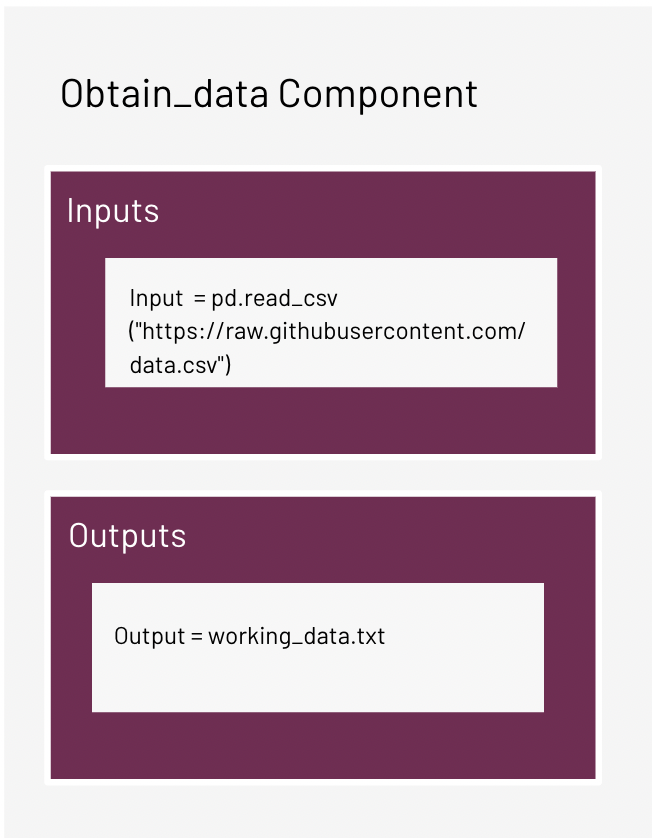

In [ ]:
def obtain_data(data_path):
    import pickle
    import sys, subprocess;
    subprocess.run([sys.executable, '-m', 'pip', 'install','pandas==0.23.4'])
    import pandas as pd
    
     #reading the data from its source
    data = pd.read_csv("https://raw.githubusercontent.com/MavenCode/KubeflowTraining/master/Data/Churn_Modelling.csv")
    #Save the data as a pickle file to be used by the preprocess component.
    with open(f'{data_path}/working_data', 'wb') as f:
        pickle.dump(data, f)

In [ ]:
obtain_data(output_dir)

### b. Defining the preprocess function

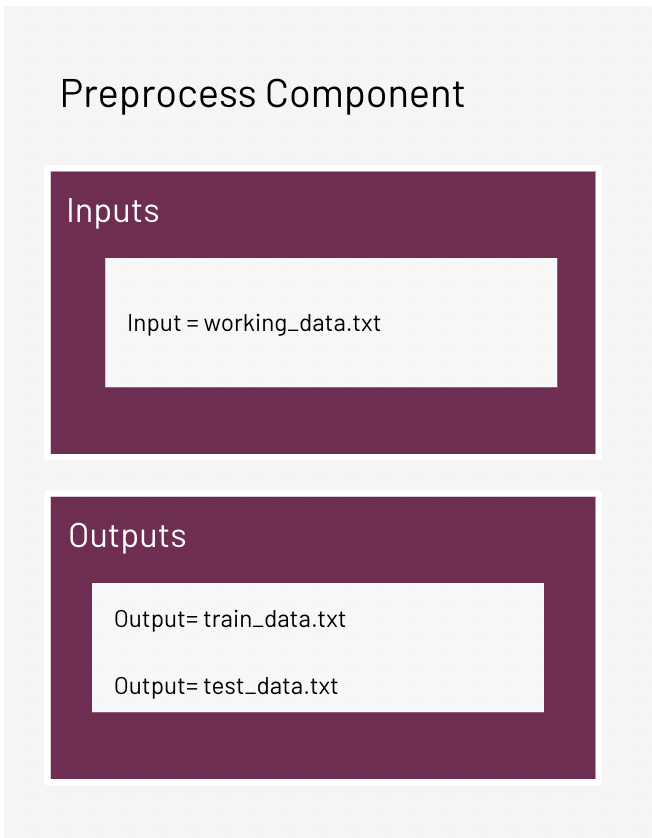

In [ ]:
def preprocessing(data_path):
    import sys, subprocess;
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'pandas==0.23.4'])
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'scikit-learn==0.22'])
    import numpy as np
    import pandas as pd
    import pickle

    from sklearn.preprocessing import LabelEncoder
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler 

  
     #loading the data
    with open(f'{data_path}/working_data', 'rb') as f:
        data = pickle.load(f)

    #dropping some columns that are not needed
    data = data.drop(columns=['RowNumber','CustomerId','Surname'], axis=1)
    #data features
    X = data.iloc[:,:-1]
    #target data
    y = data.iloc[:,-1:]   
    #encoding the categorical columns
    le = LabelEncoder()
    ohe = OneHotEncoder()
    X['Gender'] = le.fit_transform(X['Gender'])
    geo_df = pd.DataFrame(ohe.fit_transform(X[['Geography']]).toarray())

    #getting feature name after onehotencoding
    geo_df.columns = ohe.get_feature_names(['Geography'])

    #merging geo_df with the main data
    X = X.join(geo_df) 
    #dropping the old columns after encoding
    X.drop(columns=['Geography'], axis=1, inplace=True)

    #splitting the data 
    X_train,X_test,y_train,y_test = train_test_split( X,y, test_size=0.2, random_state = 42)
    #feature scaling
    sc =StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
  
    #Save the train_data as a pickle file to be used by the train component.
    with open(f'{data_path}/train_data', 'wb') as f:
        pickle.dump((X_train,  y_train), f)
        
    #Save the test_data as a pickle file to be used by the predict component.
    with open(f'{data_path}/test_data', 'wb') as f:
        pickle.dump((X_test,  y_test), f)

In [ ]:
preprocessing(output_dir)

### c.  Defining the train function

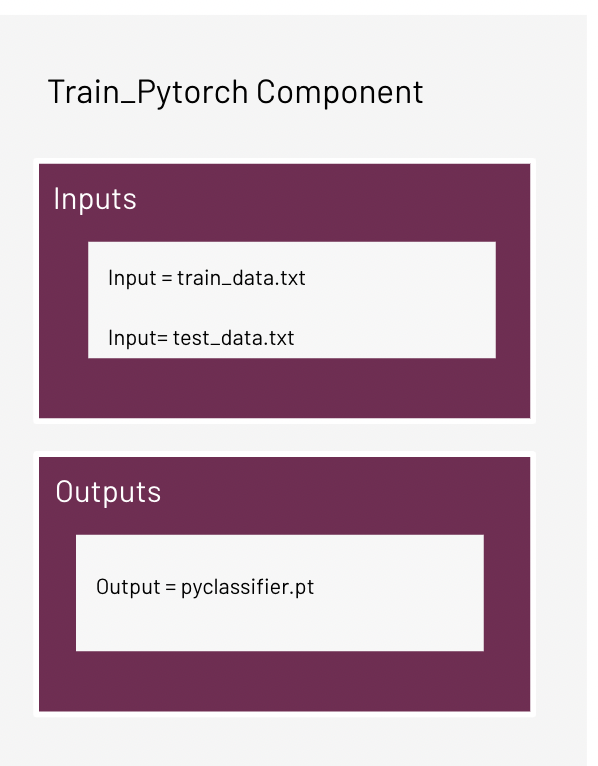

In [ ]:
def train_pytorch(data_path):
    import sys, subprocess;
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'pandas==0.23.4'])
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'scikit-learn==0.22'])
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'torch==1.7.1'])
    import pickle
    import numpy as np
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import Dataset, DataLoader
    
    #loading the train data
    with open(f'{data_path}/train_data', 'rb') as f:
        train_data = pickle.load(f)
    # Separate the X_train from y_train.
    X_train, y_train = train_data
    
    #setting model hyper-parameters
    EPOCHS = 25
    BATCH_SIZE =25
    LEARNING_RATE = 0.001
    
     #train data
    class trainData(Dataset):
        def __init__(self, X_data, y_data):
            self.X_data = X_data
            self.y_data = y_data

        def __getitem__(self,index):
            return self.X_data[index], self.y_data[index]

        def __len__(self):
            return len(self.X_data)
        
    train_data = trainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train.values))
    train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    
    #defining neural network architecture
    class binaryClassification(nn.Module):
        def __init__(self):
            super(binaryClassification, self).__init__()
            #number of input features is 12
            self.layer_1 = nn.Linear(12, 16)
            self.layer_2 = nn.Linear(16, 8)
            self.layer_out = nn.Linear(8, 1) 
            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(p=0.1)
            self.batchnorm1 = nn.BatchNorm1d(16)
            self.batchnorm2 = nn.BatchNorm1d(8)       
        #feed forward network
        def forward(self, inputs):
            x = self.relu(self.layer_1(inputs))
            x = self.batchnorm1(x)
            x = self.relu(self.layer_2(x))
            x = self.batchnorm2(x)
            x = self.dropout(x)
            x = self.layer_out(x)
            return x
    #initializing optimizer and loss
    classifier = binaryClassification()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(classifier.parameters(), lr = LEARNING_RATE)

    #function to calculate accuracy
    def binary_acc(y_pred, y_test):
        y_pred_tag = torch.round(torch.sigmoid(y_pred))
        results_sum = (y_pred_tag == y_test).sum().float()
        acc = results_sum/y_test.shape[0]
        acc =torch.round(acc*100)
        return acc
    #training the model
    classifier.train()
    for e in range(1, EPOCHS+1):
        epoch_loss = 0
        epoch_acc = 0
        for X_batch, y_batch in train_loader:
            #setting gradient to 0 per mini-batch
            optimizer.zero_grad()
            y_pred = classifier(X_batch)
            loss =criterion(y_pred, y_batch)
            acc = binary_acc(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            print(f'Epoch {e+0:03}: | Loss:{epoch_loss/len(train_loader):.5f} | Acc:{epoch_acc/len(train_loader):.3f}')
    #saving model
    torch.save(classifier.state_dict(), f'{data_path}/pyclassifier.pt')
    

In [ ]:
train_pytorch(output_dir)

### d.  Defining the predict function

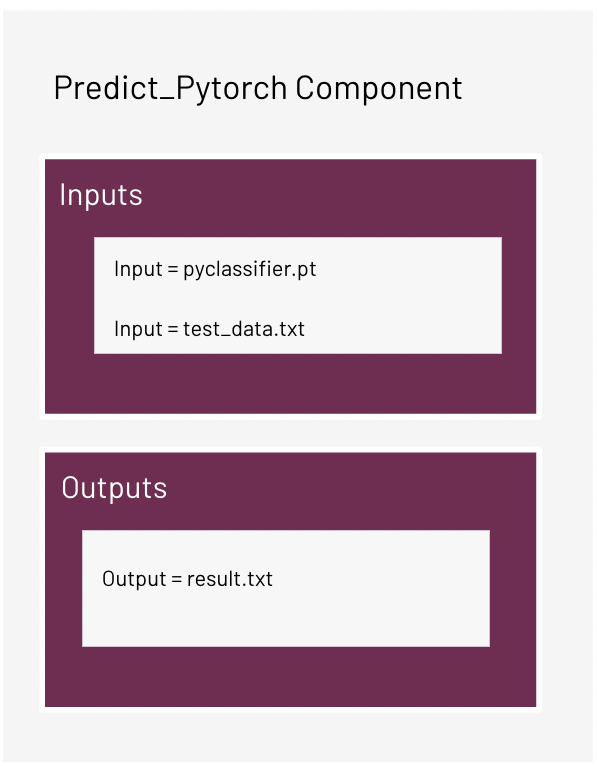

In [ ]:
def predict_pytorch(data_path):
    import sys, subprocess;
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'pandas==0.23.4'])
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'scikit-learn==0.22'])
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'torch==1.7.1'])
    import pickle
    import numpy as np
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import Dataset, DataLoader
    
    #loading the X_test and y_test data
    with open(f'{data_path}/test_data', 'rb') as f:
        test_data = pickle.load(f)
    # Separate the X_train from y_train.
    X_test, y_test = test_data
    
    #defining neural network architecture
    class binaryClassification(nn.Module):
        def __init__(self):
            super(binaryClassification, self).__init__()
            #number of input features is 12
            self.layer_1 = nn.Linear(12, 16)
            self.layer_2 = nn.Linear(16, 8)
            self.layer_out = nn.Linear(8, 1) 
            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(p=0.1)
            self.batchnorm1 = nn.BatchNorm1d(16)
            self.batchnorm2 = nn.BatchNorm1d(8)       
        #feed forward network
        def forward(self, inputs):
            x = self.relu(self.layer_1(inputs))
            x = self.batchnorm1(x)
            x = self.relu(self.layer_2(x))
            x = self.batchnorm2(x)
            x = self.dropout(x)
            x = self.layer_out(x)
            return x
    
    #loading model
    classifier = binaryClassification()
    classifier.load_state_dict(torch.load(f'{data_path}/pyclassifier.pt'))
    
     #test data
    class testData(Dataset):
        def __init__(self, X_data):
            self.X_data = X_data

        def __getitem__(self,index):
            return self.X_data[index]

        def __len__(self):
            return len(self.X_data)

    test_data = testData(torch.FloatTensor(X_test))
    test_loader = DataLoader(dataset=test_data, batch_size=1, num_workers=0)
    
    #test model
    y_pred_list = []
    classifier.eval()
    count = 0
    #ensures no back propagation during testing and reduces memeory usage
    with torch.no_grad():
        for X_batch in test_loader:
            y_test_pred = classifier(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)

            y_pred_list.append(y_pred_tag.cpu().numpy())
        y_pred_list = [i.squeeze().tolist() for i in y_pred_list] 
        y_pred_list = [bool(i) for i in y_pred_list]
    
    with open(f'{data_path}/result.txt', 'w') as result:
        result.write(" Prediction: {}, Actual: {} ".format(y_pred_list,y_test.astype(np.bool)))
    
    print('Prediction has be saved successfully!')

In [ ]:
predict_pytorch(output_dir)

Prediction has be saved successfully!


# 3. Create Kubeflow components for each step from the python functions defined above .

In [ ]:
obtain_data_op = kfp.components.create_component_from_func(obtain_data,base_image="python:3.7.1")
preprocess_op = kfp.components.create_component_from_func(preprocessing,base_image="python:3.7.1")
train_op = kfp.components.create_component_from_func(train_pytorch, base_image="pytorch/pytorch:latest")
predict_op = kfp.components.create_component_from_func(predict_pytorch, base_image="pytorch/pytorch:latest")

# 4. Define the Kubeflow Pipeline

In [ ]:
# create client that would enable communication with the Pipelines API server 
client = kfp.Client()

In [ ]:
# define pipeline
@dsl.pipeline(name="Churn Pipeline", description="Performs Preprocessing, training and prediction of churn rate")

def churn_prediction(data_path:str):
    volume_op = dsl.VolumeOp(
    name="data_volume",
    resource_name="data-volume",
    size="1Gi",
    modes=dsl.VOLUME_MODE_RWO)

     #create obtain data component
    obtain_data_container = obtain_data_op(data_path).add_pvolumes({data_path: volume_op.volume})
    # Create preprocess components.
    preprocess_container = preprocess_op(data_path).add_pvolumes({data_path: obtain_data_container.pvolume})
    # Create train component.
    train_container = train_op(data_path).add_pvolumes({data_path: preprocess_container.pvolume})
    # Create prediction component.
    predict_container = predict_op(data_path).add_pvolumes({data_path: train_container.pvolume})

    # Print the result of the prediction
    result_container = dsl.ContainerOp(
        name="print_prediction",
        image='library/bash:4.4.23',
        pvolumes={data_path: predict_container.pvolume},
        arguments=['cat', f'{data_path}/result.txt']
        )

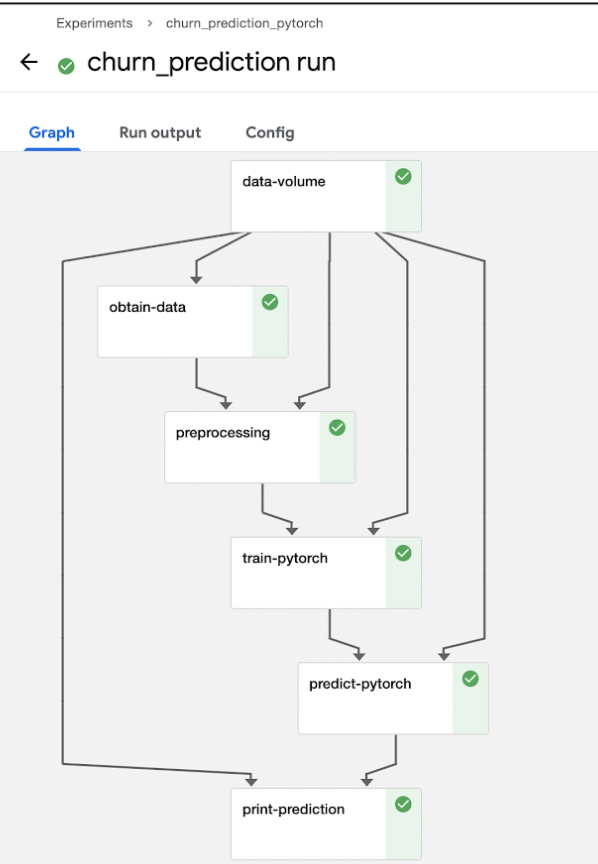

# 5. Compile and Run the Kubeflow Pipeline

In [ ]:
DATA_PATH = '/mnt/'


pipeline_func = churn_prediction

experiment_name = 'churn_prediction_pytorch'
run_name = pipeline_func.__name__ + ' run'

arguments = {"data_path":DATA_PATH}

# Compile pipeline to generate compressed YAML definition of the pipeline.
kfp.compiler.Compiler().compile(pipeline_func,'{}.zip'.format(experiment_name))

# Submit pipeline directly from pipeline function
run_result = client.create_run_from_pipeline_func(pipeline_func, 
                                                  experiment_name=experiment_name, 
                                                  run_name=run_name, 
                                                  arguments=arguments)